# DATA PREPARATION

In [678]:
import pyspark
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, IndexToString, RFormula, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model



#required imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from math import sqrt 

from bokeh.plotting import figure, output_file, show
from bokeh.models import SingleIntervalTicker, LinearAxis

## RMSE = Root Mean Square Error 
is a frequently used measure of the differences between values predicted by a model. 

It is the standard deviation of prediction errors.<br>
[RMSE](https://www.statisticshowto.datasciencecentral.com/rmse/) answers the question of how concentrated the data is around the line of best fit.
![](img/rmse.png)
Where:<br>
f = forecasts (expected values or unknown results)<br>
o = observed values (known results)

In [679]:
#load features
features = pd.read_csv("features.csv")
features.head()

,Day,Month,Season,Weekday,Holiday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes,Rented Bikes (Future)
0,1,January,Winter,Monday,False,partly-cloudy-day,fog,0.88,0.94,1.59,0.55,46.740,36.295,281,279
1,2,January,Winter,Tuesday,False,partly-cloudy-day,partly-cloudy-day,0.86,0.88,2.07,1.59,42.150,46.740,279,274
2,3,January,Winter,Wednesday,False,clear-day,partly-cloudy-day,0.86,0.86,4.13,2.07,45.450,42.150,274,161
3,4,January,Winter,Thursday,False,rain,clear-day,0.87,0.86,3.60,4.13,46.200,45.450,161,270
4,5,January,Winter,Friday,False,partly-cloudy-day,rain,0.81,0.87,7.43,3.60,56.085,46.200,270,62


In [680]:
#target variable
label = features['Rented Bikes'].tolist()

In [681]:
len(label)

1514

In [682]:
#transorm non-numerical labels to numerical labels
le = LabelEncoder()
features.loc[:,'Holiday'] = le.fit_transform(features['Holiday'])
features.head()

,Day,Month,Season,Weekday,Holiday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes,Rented Bikes (Future)
0,1,January,Winter,Monday,0,partly-cloudy-day,fog,0.88,0.94,1.59,0.55,46.740,36.295,281,279
1,2,January,Winter,Tuesday,0,partly-cloudy-day,partly-cloudy-day,0.86,0.88,2.07,1.59,42.150,46.740,279,274
2,3,January,Winter,Wednesday,0,clear-day,partly-cloudy-day,0.86,0.86,4.13,2.07,45.450,42.150,274,161
3,4,January,Winter,Thursday,0,rain,clear-day,0.87,0.86,3.60,4.13,46.200,45.450,161,270
4,5,January,Winter,Friday,0,partly-cloudy-day,rain,0.81,0.87,7.43,3.60,56.085,46.200,270,62


In [676]:
#transorm non-numerical labels to numerical labels
cleanup_nums = {"Month":   {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12},
               "Season": {"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4},
               "Weekday": {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4,
                                  "Friday": 5, "Saturday": 6, "Sunday":7 },
               "Daily Weather": {"clear-day": 1, "partly-cloudy-day": 2,"cloudy":3,"wind":4, "rain": 5, "fog": 6, "snow": 7},
               "Daily Weather (Past)": {"clear-day": 1, "partly-cloudy-day": 2,"cloudy":3,"wind":4, "rain": 5,"fog": 6, "snow": 7} }

In [683]:
features.replace(cleanup_nums, inplace=True)

In [684]:
features.head()

,Day,Month,Season,Weekday,Holiday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes,Rented Bikes (Future)
0,1,1,4,1,0,2,6,0.88,0.94,1.59,0.55,46.740,36.295,281,279
1,2,1,4,2,0,2,2,0.86,0.88,2.07,1.59,42.150,46.740,279,274
2,3,1,4,3,0,1,2,0.86,0.86,4.13,2.07,45.450,42.150,274,161
3,4,1,4,4,0,5,1,0.87,0.86,3.60,4.13,46.200,45.450,161,270
4,5,1,4,5,0,2,5,0.81,0.87,7.43,3.60,56.085,46.200,270,62


In [685]:
features.shape

(1514, 15)

In [936]:
#Feature Matrix with past and today data
#X=features.loc[:,['Day','Month','Season','Daily Weather','Daily Weather (Past)','Humidity','Humidity (Past)','Windspeed', 'Windspeed (Past)', 'Apparent Temperature (Avg)','Apparent Temperature (Avg) (Past)','Rented Bikes (Future)']]
X=features.loc[:,['Day','Month','Season','Weekday', 'Daily Weather','Daily Weather (Past)','Humidity','Humidity (Past)', 'Windspeed', 'Windspeed (Past)', 'Apparent Temperature (Avg)','Apparent Temperature (Avg) (Past)','Rented Bikes (Future)']]
X.head()

,Day,Month,Season,Weekday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes (Future)
0,1,1,4,1,2,6,0.88,0.94,1.59,0.55,46.740,36.295,279
1,2,1,4,2,2,2,0.86,0.88,2.07,1.59,42.150,46.740,274
2,3,1,4,3,1,2,0.86,0.86,4.13,2.07,45.450,42.150,161
3,4,1,4,4,5,1,0.87,0.86,3.60,4.13,46.200,45.450,270
4,5,1,4,5,2,5,0.81,0.87,7.43,3.60,56.085,46.200,62


In [977]:
X['label'] = label

In [688]:
#_4 test1
#X.to_csv('raw_files/encoded_last_4.csv')

In [1251]:


# Below code is Spark 2+
spark = pyspark.sql.SparkSession.builder.appName('test').getOrCreate()
df = spark.read.csv('raw_files/encoded_last_4.csv', header = True, inferSchema = True)
df_bis=df.toPandas()

In [1252]:
df.show(5)

+---+---+-----+------+-------+-------------+--------------------+--------+---------------+---------+----------------+--------------------------+---------------------------------+---------------------+-----+
|_c0|Day|Month|Season|Weekday|Daily Weather|Daily Weather (Past)|Humidity|Humidity (Past)|Windspeed|Windspeed (Past)|Apparent Temperature (Avg)|Apparent Temperature (Avg) (Past)|Rented Bikes (Future)|label|
+---+---+-----+------+-------+-------------+--------------------+--------+---------------+---------+----------------+--------------------------+---------------------------------+---------------------+-----+
|  0|  1|    1|     4|      1|            2|                   6|    0.88|           0.94|     1.59|            0.55|                     46.74|                           36.295|                  279|  281|
|  1|  2|    1|     4|      2|            2|                   2|    0.86|           0.88|     2.07|            1.59|                     42.15|                            

In [1234]:
df.columns

['_c0',
 'Day',
 'Month',
 'Season',
 'Weekday',
 'Daily Weather',
 'Daily Weather (Past)',
 'Humidity',
 'Humidity (Past)',
 'Windspeed',
 'Windspeed (Past)',
 'Apparent Temperature (Avg)',
 'Apparent Temperature (Avg) (Past)',
 'Rented Bikes (Future)',
 'label']

In [1253]:
#cols = df.columns
#categoricalColumns = [, "Daily Weather (Past)"]

#cols = ['Day','Month','Season','Weekday', 'Daily Weather','Daily Weather (Past)','Humidity','Humidity (Past)', 'Windspeed', 'Windspeed (Past)', 'Apparent Temperature (Avg)','Apparent Temperature (Avg) (Past)','Rented Bikes (Future)']


#(best RMSE for decision tree) 
#cols = [ "Humidity", "Weekday","Month", "Apparent Temperature (Avg)", "Rented Bikes (Future)"]

#(best RMSE for random forest) 
#cols = ['Day','Month','Season','Weekday', 'Daily Weather','Humidity','Humidity (Past)', 'Windspeed', 'Windspeed (Past)', 'Apparent Temperature (Avg)','Apparent Temperature (Avg) (Past)','Rented Bikes (Future)']

#(best RMSE for Gradient boost) 
cols = ['Day','Month','Weekday','Humidity','Humidity (Past)', 'Windspeed', 'Windspeed (Past)', 'Apparent Temperature (Avg)','Apparent Temperature (Avg) (Past)','Rented Bikes (Future)']

stages = [] # stages in our Pipeline


assembler = VectorAssembler(inputCols= cols , outputCol="features").setHandleInvalid("skip")

preppedDataDF = assembler.transform(df)

#scaler = StandardScaler(inputCol="features"  , outputCol="scaledFeatures",
                        #withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
#scalerModel = scaler.fit(preppedDataDF)
# Normalize each feature to have unit standard deviation.
#preppedDataDF = scalerModel.transform(preppedDataDF)

In [1236]:
preppedDataDF.show(5)

+---+---+-----+------+-------+-------------+--------------------+--------+---------------+---------+----------------+--------------------------+---------------------------------+---------------------+-----+--------------------+
|_c0|Day|Month|Season|Weekday|Daily Weather|Daily Weather (Past)|Humidity|Humidity (Past)|Windspeed|Windspeed (Past)|Apparent Temperature (Avg)|Apparent Temperature (Avg) (Past)|Rented Bikes (Future)|label|            features|
+---+---+-----+------+-------+-------------+--------------------+--------+---------------+---------+----------------+--------------------------+---------------------------------+---------------------+-----+--------------------+
|  0|  1|    1|     4|      1|            2|                   6|    0.88|           0.94|     1.59|            0.55|                     46.74|                           36.295|                  279|  281|[0.88,1.0,1.0,46....|
|  1|  2|    1|     4|      2|            2|                   2|    0.86|           0.8

In [1200]:
preppedDataDF.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- Daily Weather: integer (nullable = true)
 |-- Daily Weather (Past): integer (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Humidity (Past): double (nullable = true)
 |-- Windspeed: double (nullable = true)
 |-- Windspeed (Past): double (nullable = true)
 |-- Apparent Temperature (Avg): double (nullable = true)
 |-- Apparent Temperature (Avg) (Past): double (nullable = true)
 |-- Rented Bikes (Future): integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [1254]:
# Keep relevant columns
selectedcols = ["features", "label","Day"]
dataset = preppedDataDF.select(selectedcols)
display(dataset)



DataFrame[features: vector, label: int, Day: int]

In [1255]:
dataset.show(5)

+--------------------+-----+---+
|            features|label|Day|
+--------------------+-----+---+
|[1.0,1.0,1.0,0.88...|  281|  1|
|[2.0,1.0,2.0,0.86...|  279|  2|
|[3.0,1.0,3.0,0.86...|  274|  3|
|[4.0,1.0,4.0,0.87...|  161|  4|
|[5.0,1.0,5.0,0.81...|  270|  5|
+--------------------+-----+---+
only showing top 5 rows



In [1256]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
### Randomly split data into training and test sets. set seed for reproducibility
#(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
#print(trainingData.count())
#print(testData.count())

In [1257]:
# create a dummy df with 500 rows and 2 columns
N = dataset.count()


# sort ascending and take first 100 rows for df1
trainingData= dataset.sort('Day').limit(1055)

# sort descending and take 400 rows for df2
testData = dataset.sort('Day', ascending=False).limit(450)

print(trainingData.count())
print(testData.count())

1055
450


In [1258]:
trainingData.show(5)

+--------------------+-----+---+
|            features|label|Day|
+--------------------+-----+---+
|[1.0,1.0,1.0,0.88...|  281|  1|
|[2.0,1.0,2.0,0.86...|  279|  2|
|[3.0,1.0,3.0,0.86...|  274|  3|
|[4.0,1.0,4.0,0.87...|  161|  4|
|[5.0,1.0,5.0,0.81...|  270|  5|
+--------------------+-----+---+
only showing top 5 rows



AttributeError: 'DataFrame' object has no attribute 'array'

  #  Generaliszed linear regression
  
  Contrasted with linear regression where the output is assumed to follow a Gaussian distribution, generalized linear models (GLMs) are specifications of linear models where the response variable Yi follows some distribution from the exponential family of distributions. 
  
  Spark currently only supports up to 4096 features through its GeneralizedLinearRegression interface

In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="Poisson", link="identity", maxIter=10, regParam=0.3)
#"Gamma"--> RMSE =100.975
#"Poisson"--> RMSE =98.315


# Fit the model
model = glr.fit(dataset)

# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

# Summarize the model over the training set and print out some metrics
summary = model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

In [ ]:
predictions = model.transform(testData)
predictions.select("label","features","prediction").toPandas().head()


In [ ]:
dfs_glr= predictions.toPandas()
a=dfs_glr.loc[:,'label']
b=dfs_glr.loc[:,'prediction']
rmse=sqrt(mean_squared_error(a, b))  
"The root mean square error of the model is {0:.3f}".format(rmse) 

In [ ]:
label

# Decision tree regression

In [1239]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator



# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(trainingData)


# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures",impurity='variance')
 
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions_dt_test = model.transform(testData)
# Select example rows to display.
pred_dt_test= predictions_dt_test.select("prediction", "label" ,"Day").orderBy('Day', ascending=True).toPandas()


# Select example rows to display.
#predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_dt_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)
pred_dt_test.head()

Root Mean Squared Error (RMSE) on test data = 52.841
DecisionTreeRegressionModel (uid=DecisionTreeRegressor_0bd8e9e95d49) of depth 5 with 63 nodes


,prediction,label,Day
0,272.666667,331,1065
1,272.666667,313,1066
2,272.666667,267,1067
3,95.909091,233,1068
4,233.727273,151,1069


In [497]:
trainingData.count()

1055

In [1240]:
predictions_dt_training = model.transform(trainingData)
# Select example rows to display.
pred_dt_training= predictions_dt_training.select("prediction", "label" ,"Day").orderBy('Day', ascending=True).toPandas()


# Select example rows to display.
#predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_dt_training)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse)

#treeModel = model.stages[1]
# summary only
pred_dt_training.head()

Root Mean Squared Error (RMSE) on training data = 51.1435


,prediction,label,Day
0,259.818182,281,1
1,318.290837,279,2
2,318.290837,274,3
3,318.290837,161,4
4,318.290837,270,5


In [1241]:
pred_dt_training.values[:,2]

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.053e+03, 1.054e+03,
       1.055e+03])

In [1242]:
output_dt_bis = pd.merge(pred_dt_test,pred_dt_training, how='outer').sort_values('Day', ascending=True)
output_dt = pd.merge(df_bis, output_dt_bis, how='outer', on='Day')
output_dt.head()

,_c0,Day,Month,Season,Weekday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes (Future),label_x,prediction,label_y
0,0,1,1,4,1,2,6,0.88,0.94,1.59,0.55,46.740,36.295,279,281,259.818182,281.0
1,1,2,1,4,2,2,2,0.86,0.88,2.07,1.59,42.150,46.740,274,279,318.290837,279.0
2,2,3,1,4,3,1,2,0.86,0.86,4.13,2.07,45.450,42.150,161,274,318.290837,274.0
3,3,4,1,4,4,5,1,0.87,0.86,3.60,4.13,46.200,45.450,270,161,318.290837,161.0
4,4,5,1,4,5,2,5,0.81,0.87,7.43,3.60,56.085,46.200,62,270,318.290837,270.0


In [290]:
#output_dt.values[:,1]

In [ ]:
plt.figure(figsize=(26,8))

plt.subplot(131)
plt.scatter(output_dt.values[:,1], output_dt.values[:,2], color = 'blue',label='Real future Value')  
plt.legend()
plt.xticks(np.arange(0, 1000, step=100))
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Actual data")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")



plt.subplot(132)
plt.scatter(output_dt.values[:,0], output_dt.values[:,2], color = 'red',label='Algorthm prediction') 
plt.legend()
plt.xticks(np.arange(0, 1000, step=100))
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Decision tree prediction")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")

plt.show()

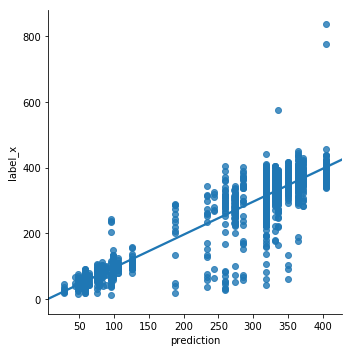

In [1244]:
import seaborn as sns

sns.lmplot(x='prediction', y='label_x', data=output_dt)

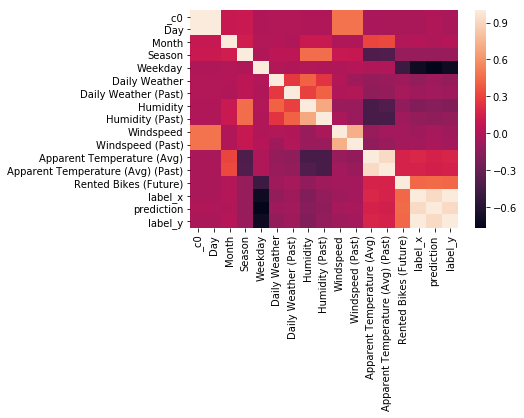

In [1245]:
# Calculate correlations
corr = output_dt.corr()
 
# Heatmap
sns.heatmap(corr)

In [1246]:
pred_dt.head()
#pred_dt.count()



,prediction,label,_c0,Day
0,389.0,360,1253,1254
1,108.0,102,1259,1260
2,350.0,421,177,178
3,436.0,410,486,487
4,406.0,838,185,186


In [1247]:
df_bis.head()

,_c0,Day,Month,Season,Weekday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes (Future),label
0,0,1,1,4,1,2,6,0.88,0.94,1.59,0.55,46.740,36.295,279,281
1,1,2,1,4,2,2,2,0.86,0.88,2.07,1.59,42.150,46.740,274,279
2,2,3,1,4,3,1,2,0.86,0.86,4.13,2.07,45.450,42.150,161,274
3,3,4,1,4,4,5,1,0.87,0.86,3.60,4.13,46.200,45.450,270,161
4,4,5,1,4,5,2,5,0.81,0.87,7.43,3.60,56.085,46.200,62,270


Text(0.5,1,'feature importancy')

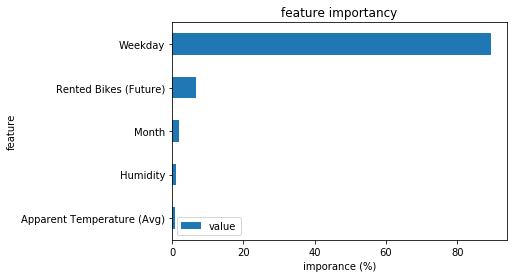

In [1248]:
#treeModel.featureImportances
from pandas.io.json import json_normalize
#remove Month, Humidity(past), Season, Daily weather, Daily weather(Past), Weekday
#print(json_normalize(dict(zip(df_bis.columns, treeModel.featureImportances))))

jdata = dict(zip(cols, treeModel.featureImportances))

df = pd.DataFrame.from_dict(json_normalize(jdata), orient='columns')

dfsum=pd.melt(df)# Count Plot (a.k.a. Bar Plot)
df

dfsum['value'] *= 100

ax = dfsum.plot(kind='barh')
ax.set_xlabel('imporance (%)')
ax.set_ylabel("feature")
ax.set_yticklabels(dfsum.variable)
ax.set_title("feature importancy")

In [1249]:
x1 = output_dt.values[:,1].astype(int) #day
x3 = pred_dt_training.values[:,2].astype(int) #day
x2 = pred_dt_test.values[:,2].astype(int) #day


y1 = output_dt.loc[:,'label_x'] #actual
y3 = pred_dt_training.values[:,0].astype(int) #prediction train
y2 = pred_dt_test.values[:,0] #prediction test



# output to static HTML file
output_file("DecisionTree.html")
p = figure(
   tools="pan,box_zoom,wheel_zoom,reset,save",
    title="Decsion Tree Regression Prediction",
    y_range=[1, 850],
    x_range=[0, 1600],
   x_axis_label='Days', y_axis_label='Frequency',
    plot_width=2000, plot_height=350,
    x_axis_type=None,
    toolbar_location="left"
)
#set xticks
tickerx = SingleIntervalTicker(interval=1, num_minor_ticks=1)
xaxis = LinearAxis(ticker=tickerx)
p.add_layout(xaxis, 'below')
# add a line renderer with legend and line thickness
p.ray(x=1212, y=0, length=800, angle=1.57079633, color='purple')
p.line(x1, y1, legend="Actual", line_color="green")
p.line(x2, y2, legend="Predicted Test", line_color="blue")
p.line(x3, y3, legend="Predicted Training", line_color="red")
p.xaxis.major_label_orientation = 'vertical'
# show the results
show(p)

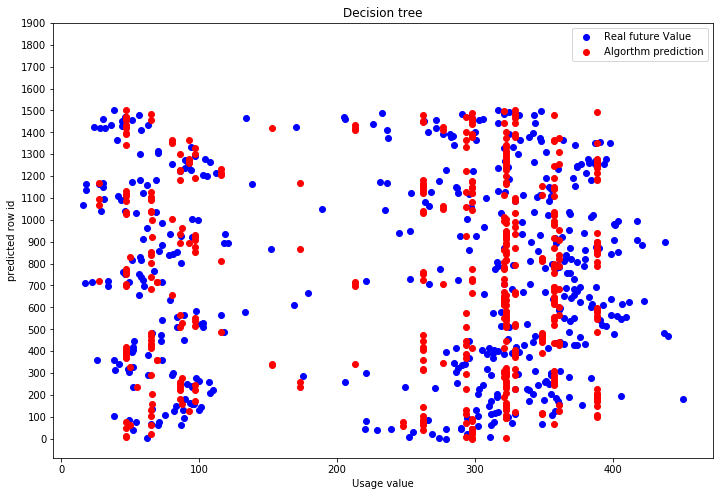

In [216]:
plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(output_dt.values[:,0], output_dt.values[:,2], color = 'red',label='Prediction') 
plt.scatter(output_dt.values[:,10], output_dt.values[:,2], color = 'blue',label='Real future value')
plt.legend()
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Decision tree")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")
plt.show()

# Random forest regression

In [1217]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator


# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)



# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures",numTrees=30, maxDepth=30)
#20 tree : RMSE= 67.47
#20 tree : RMSE= 71.47
#numTrees=10, maxDepth=10, maxBins=32; RMSE= 64.34
#numTrees=15, maxDepth=15, maxBins=30; RMSE= 64.19

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions_rd_test = model.transform(testData)

# Select example rows to display.
pred_rd_test= predictions_rd_test.select("prediction", "label" ,"Day").orderBy('Day', ascending=True).toPandas()
pred_rd_test.head()

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_rd_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

pred_rd_test.head()

Root Mean Squared Error (RMSE) on test data = 53.8435
RandomForestRegressionModel (uid=RandomForestRegressor_b1b628845264) with 30 trees


,prediction,label,Day
0,328.833333,331,1065
1,329.366667,313,1066
2,301.266667,267,1067
3,258.066667,233,1068
4,265.666667,151,1069


In [1218]:
# Make predictions.
predictions_rd_training = model.transform(trainingData)

# Select example rows to display.
pred_rd_training= predictions_rd_training.select("prediction", "label" ,"Day").orderBy('Day', ascending=True).toPandas()
pred_rd_training.head()

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_rd_training)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

pred_rd_training.head()

Root Mean Squared Error (RMSE) on test data = 22.1483
RandomForestRegressionModel (uid=RandomForestRegressor_b1b628845264) with 30 trees


,prediction,label,Day
0,276.400000,281,1
1,284.533333,279,2
2,279.100000,274,3
3,213.133333,161,4
4,255.133333,270,5


[Text(0,0,'Apparent Temperature (Avg)'),
 Text(0,0,'Apparent Temperature (Avg) (Past)'),
 Text(0,0,'Daily Weather'),
 Text(0,0,'Day'),
 Text(0,0,'Humidity'),
 Text(0,0,'Humidity (Past)'),
 Text(0,0,'Month'),
 Text(0,0,'Rented Bikes (Future)'),
 Text(0,0,'Season'),
 Text(0,0,'Weekday'),
 Text(0,0,'Windspeed'),
 Text(0,0,'Windspeed (Past)')]

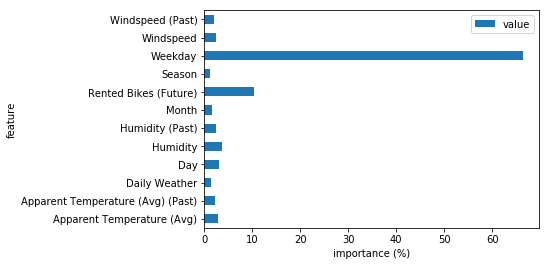

In [1219]:
#treeModel.featureImportances
from pandas.io.json import json_normalize
#remove Month, Humidity(past), Season, Daily weather, Daily weather(Past), Weekday
#print(json_normalize(dict(zip(df_bis.columns, treeModel.featureImportances))))

jdata = dict(zip(cols, rfModel.featureImportances))

df = pd.DataFrame.from_dict(json_normalize(jdata), orient='columns')

dfsum=pd.melt(df)# Count Plot (a.k.a. Bar Plot)


dfsum['value'] *= 100

ax = dfsum.plot(kind='barh')
ax.set_xlabel('importance (%)')
ax.set_ylabel("feature")
ax.set_yticklabels(dfsum.variable)

In [762]:
output_rd_bis = pd.merge(pred_rd_test,pred_rd_training, how='outer').sort_values('Day', ascending=True)
output_rd = pd.merge(df_bis, output_rd_bis, how='outer', on='Day')
output_rd.head()

,_c0,Day,Month,Season,Weekday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes (Future),label_x,prediction,label_y
0,0,1,1,4,1,2,6,0.88,0.94,1.59,0.55,46.740,36.295,279,281,261.133333,281.0
1,1,2,1,4,2,2,2,0.86,0.88,2.07,1.59,42.150,46.740,274,279,282.533333,279.0
2,2,3,1,4,3,1,2,0.86,0.86,4.13,2.07,45.450,42.150,161,274,278.266667,274.0
3,3,4,1,4,4,5,1,0.87,0.86,3.60,4.13,46.200,45.450,270,161,214.166667,161.0
4,4,5,1,4,5,2,5,0.81,0.87,7.43,3.60,56.085,46.200,62,270,276.300000,270.0


In [194]:
# 450 samples

In [ ]:
plt.figure(figsize=(26,8))

plt.subplot(131)
plt.scatter(output.values[:,10], output.values[:,2], color = 'blue',label='Actual Value')  
plt.legend()
plt.xticks(np.arange(0, 1000, step=100))
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Actual data")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")



plt.subplot(132)
plt.scatter(output.values[:,0], output.values[:,2], color = 'red',label='Real future Value') 
plt.legend()
plt.xticks(np.arange(0, 1000, step=100))
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Random forest Prediction")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")

plt.show()

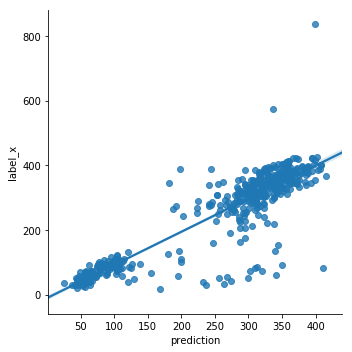

In [1220]:
sns.lmplot(x='prediction', y='label_x', data=output)

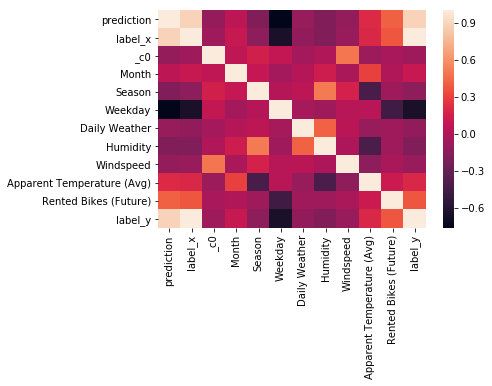

In [1221]:
# Calculate correlations
corr = output.corr()
 
# Heatmap
sns.heatmap(corr)

In [1222]:
x1 = output_rd.values[:,1].astype(int) #day
x3 = pred_rd_training.values[:,2].astype(int) #day
x2 = pred_rd_test.values[:,2].astype(int) #day


y1 = output_rd.loc[:,'label_x'] #actual
y3 = pred_rd_training.values[:,0].astype(int) #prediction train
y2 = pred_rd_test.values[:,0] #prediction test



# output to static HTML file
output_file("RandomForest.html")
p = figure(
   tools="pan,box_zoom,wheel_zoom,reset,save",
    title="Random Forest Regression Prediction",
    y_range=[1, 850],
    x_range=[0, 1600],
   x_axis_label='Days', y_axis_label='Frequency',
    plot_width=2000, plot_height=350,
    x_axis_type=None,
    toolbar_location="left"
)
#set xticks
tickerx = SingleIntervalTicker(interval=1, num_minor_ticks=1)
xaxis = LinearAxis(ticker=tickerx)
p.add_layout(xaxis, 'below')
# add a line renderer with legend and line thickness
p.ray(x=1212, y=0, length=800, angle=1.57079633, color='purple')
p.line(x1, y1, legend="Actual", line_color="green")
p.line(x2, y2, legend="Predicted Test", line_color="blue")
p.line(x3, y3, legend="Predicted Training", line_color="red")
p.xaxis.major_label_orientation = 'vertical'
# show the results
show(p)


In [ ]:
plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(output.values[:,0], output.values[:,2], color = 'red',label='Prediction') 
plt.scatter(output.values[:,10], output.values[:,2], color = 'blue',label='Real future value')
plt.legend()
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Random forest")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")
plt.show()

# Gradient-boosted tree regression

In [1259]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator



# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)


# Train a GBT model.
gbt = GBTRegressor(featuresCol="indexedFeatures")
#40 tree : RMSE= 67.47
#10 tree: RMSE= 66
#100 tree : RMSE= 67.6202

# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, gbt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions_tr_test = model.transform(testData)

# Select example rows to display.
pred_tr_test= predictions_tr_test.select("prediction", "label" ,"Day").orderBy('Day', ascending=True).toPandas()


# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_tr_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbtModel = model.stages[1]
print(gbtModel)  # summary only

pred_tr_test.head()

Root Mean Squared Error (RMSE) on test data = 58.7994
GBTRegressionModel (uid=GBTRegressor_d0207eb2747a) with 20 trees


,prediction,label,Day
0,237.055263,331,1065
1,287.905040,313,1066
2,279.518437,267,1067
3,111.118291,233,1068
4,263.374059,151,1069


In [1260]:
# Make predictions.
predictions_tr_training = model.transform(trainingData)

# Select example rows to display.
pred_tr_training= predictions_tr_training.select("prediction", "label" ,"Day").orderBy('Day', ascending=True).toPandas()


# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_tr_training)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbtModel = model.stages[1]
print(gbtModel)  # summary only

pred_tr_training.head()

Root Mean Squared Error (RMSE) on test data = 29.2585
GBTRegressionModel (uid=GBTRegressor_d0207eb2747a) with 20 trees


,prediction,label,Day
0,238.875150,281,1
1,294.731777,279,2
2,275.225166,274,3
3,271.271269,161,4
4,273.010655,270,5


In [1261]:
output_tr = pd.merge(pred_tr,df_bis,how='left', on='_c0')
output_tr.head()

,prediction,label_x,_c0,Day,Month,Season,Weekday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes (Future),label_y
0,377.656539,360,1253,1254,6,2,1,1,2,0.50,0.51,0.75,2.63,69.465,65.360,387,360
1,94.178009,102,1259,1260,7,2,7,1,2,0.51,0.58,8.14,9.95,74.225,69.730,383,102
2,376.827900,421,177,178,7,2,3,2,1,0.52,0.57,2.63,2.22,78.645,76.140,350,421
3,391.374272,410,486,487,5,1,4,1,1,0.53,0.58,2.21,1.86,56.195,53.620,368,410
4,412.926105,838,185,186,7,2,4,2,2,0.55,0.69,1.77,4.07,62.970,60.415,359,838


[Text(0,0,'Apparent Temperature (Avg)'),
 Text(0,0,'Apparent Temperature (Avg) (Past)'),
 Text(0,0,'Day'),
 Text(0,0,'Humidity'),
 Text(0,0,'Humidity (Past)'),
 Text(0,0,'Month'),
 Text(0,0,'Rented Bikes (Future)'),
 Text(0,0,'Weekday'),
 Text(0,0,'Windspeed'),
 Text(0,0,'Windspeed (Past)')]

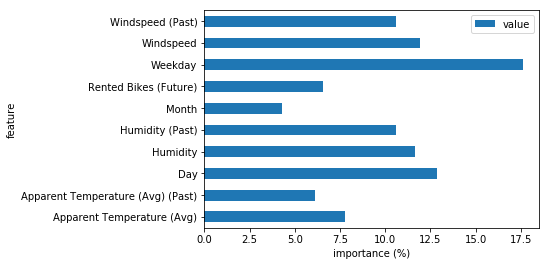

In [1262]:
#treeModel.featureImportances
from pandas.io.json import json_normalize
#remove Month, Humidity(past), Season, Daily weather, Daily weather(Past), Weekday
#print(json_normalize(dict(zip(df_bis.columns, treeModel.featureImportances))))

jdata = dict(zip(cols, gbtModel.featureImportances))

df = pd.DataFrame.from_dict(json_normalize(jdata), orient='columns')

dfsum=pd.melt(df)# Count Plot (a.k.a. Bar Plot)


dfsum['value'] *= 100

ax = dfsum.plot(kind='barh')
ax.set_xlabel('importance (%)')
ax.set_ylabel("feature")
ax.set_yticklabels(dfsum.variable)

In [1263]:
output_tr_bis = pd.merge(pred_tr_test,pred_tr_training, how='outer').sort_values('Day', ascending=True)
output_tr = pd.merge(df_bis, output_tr_bis, how='outer', on='Day')
output_tr.head()

,_c0,Day,Month,Season,Weekday,Daily Weather,Daily Weather (Past),Humidity,Humidity (Past),Windspeed,Windspeed (Past),Apparent Temperature (Avg),Apparent Temperature (Avg) (Past),Rented Bikes (Future),label_x,prediction,label_y
0,0,1,1,4,1,2,6,0.88,0.94,1.59,0.55,46.740,36.295,279,281,238.875150,281.0
1,1,2,1,4,2,2,2,0.86,0.88,2.07,1.59,42.150,46.740,274,279,294.731777,279.0
2,2,3,1,4,3,1,2,0.86,0.86,4.13,2.07,45.450,42.150,161,274,275.225166,274.0
3,3,4,1,4,4,5,1,0.87,0.86,3.60,4.13,46.200,45.450,270,161,271.271269,161.0
4,4,5,1,4,5,2,5,0.81,0.87,7.43,3.60,56.085,46.200,62,270,273.010655,270.0


In [ ]:
plt.figure(figsize=(26,8))

plt.subplot(131)
plt.scatter(output_tr.values[:,10], output_tr.values[:,2], color = 'blue',label='Actual Value')  
plt.legend()
plt.xticks(np.arange(0, 1000, step=100))
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Actual data")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")



plt.subplot(132)
plt.scatter(output_tr.values[:,0], output_tr.values[:,2], color = 'red',label='Real future Value') 
plt.legend()
plt.xticks(np.arange(0, 1000, step=100))
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Grdient boosted regression")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")

plt.show()

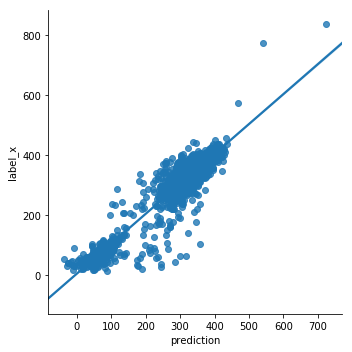

In [1265]:
sns.lmplot(x='prediction', y='label_x', data=output_tr)

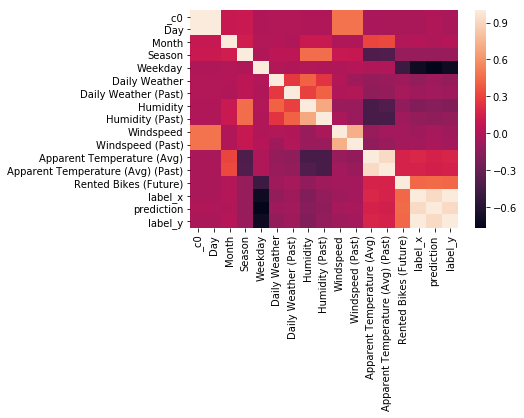

In [1266]:
# Calculate correlations
corr = output_dt.corr()
 
# Heatmap
sns.heatmap(corr)

In [1267]:
x1 = output_tr.values[:,1].astype(int) #day
x3 = pred_tr_training.values[:,2].astype(int) #day
x2 = pred_tr_test.values[:,2].astype(int) #day


y1 = output_tr.loc[:,'label_x'] #actual
y3 = pred_tr_training.values[:,0].astype(int) #prediction train
y2 = pred_tr_test.values[:,0] #prediction test



# output to static HTML file
output_file("GradientBooseted.html")
p = figure(
   tools="pan,box_zoom,wheel_zoom,reset,save",
    title="Gradient-boosted tree Prediction",
    y_range=[1, 850],
    x_range=[0, 1600],
   x_axis_label='Days', y_axis_label='Frequency',
    plot_width=2000, plot_height=350,
    x_axis_type=None,
    toolbar_location="left"
)
#set xticks
tickerx = SingleIntervalTicker(interval=1, num_minor_ticks=1)
xaxis = LinearAxis(ticker=tickerx)
p.add_layout(xaxis, 'below')
# add a line renderer with legend and line thickness
p.ray(x=1212, y=0, length=800, angle=1.57079633, color='purple')
p.line(x1, y1, legend="Actual", line_color="green")
p.line(x2, y2, legend="Predicted Test", line_color="blue")
p.line(x3, y3, legend="Predicted Training", line_color="red")
p.xaxis.major_label_orientation = 'vertical'
# show the results
show(p)


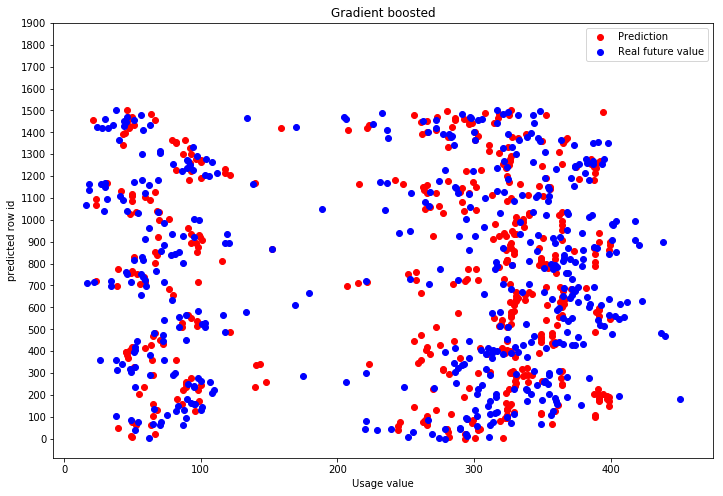

In [229]:
plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(output_tr.values[:,0], output_tr.values[:,2], color = 'red',label='Prediction') 
plt.scatter(output_tr.values[:,10], output_tr.values[:,2], color = 'blue',label='Real future value')
plt.legend()
plt.yticks(np.arange(0, 2000, step=100))
plt.title("Gradient boosted")
plt.ylabel("predicted row id")
plt.xlabel("Usage value")
plt.show()

In [1293]:
pandaDf = trainingData.toPandas()

X = pandaDf['features'].values.reshape(-1,1)
y = pandaDf['label'].values.reshape(-1,1)



# Multi-layer perceptron

In [1294]:
from sklearn.neural_network import MLPClassifier
import datetime as dt


nn_1_10 = MLPClassifier(hidden_layer_sizes=(10),
                   activation='logistic',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=50,
                   learning_rate='constant',
#                   learning_rate='invscaling',
                   learning_rate_init=0.001,
#                   power_t=0.00001,
                   max_iter=1000,
                   verbose=True,
                   random_state=1)



start = dt.datetime.now()
nn_1_10.fit(X, y)
end = dt.datetime.now()

print('It took {} to train the neural network'.format(end-start))

y_train_pred = nn_1_10.predict(trainingData)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

y_test_pred = nn_1_10.predict(testData)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))


ValueError: setting an array element with a sequence.